In [143]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# User defined functions

In [5]:
def CalcPooling(input_dim,kernel_dim,stride,dilation=1,padding=0):
    result = int(((input_dim+2*padding-dilation*(kernel_dim-1)-1)/stride)+1)
    return result

In [6]:
def CalcDimensionality(input_dim,kernel_dim,stride,padding=0):
    result = int(((input_dim-kernel_dim+2*padding)/stride)+1)
    return result

# Load the data

In [12]:
## LOAD the mnist data. 

# To speed up training we'll only work on a subset of the data.
# Note that we reshape the data from 
#  (nsamples, num_features) = (nsamples, nchannels*rows*cols)
#    -> (nsamples, nchannels, rows, cols)
# in order to retain the spatial arrangements of the pixels
data = np.load('mnist.npz')
num_classes = 10
nchannels, rows, cols = 1, 28, 28

x_train = data['X_train'][:1000].astype('float32')
x_train = x_train.reshape((-1, nchannels, rows, cols))
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
x_valid = x_valid.reshape((-1, nchannels, rows, cols))
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
x_test = x_test.reshape((-1, nchannels, rows, cols))
targets_test = data['y_test'][:500].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train (1000, 1, 28, 28)
targets_train (1000,)
x_valid (500, 1, 28, 28)
targets_valid (500,)
x_test (500, 1, 28, 28)
targets_test (500,)


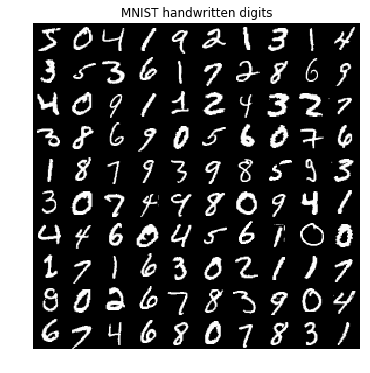

In [13]:
## plot a few MNIST examples

idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

# Define network

In [34]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(28*28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Test the network with an input

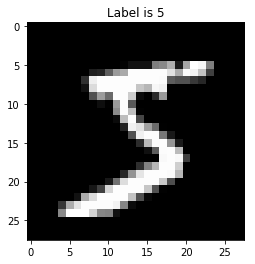

In [44]:
# Reshape the array into 28 x 28 array (2-dimensional array)
pixels = x_train[0].reshape((28, 28))

# Plot
plt.title('Label is {label}'.format(label=targets_train[0]))
plt.imshow(pixels, cmap='gray')
plt.show()

In [35]:
# change the numpy array data to tensor format
x = torch.from_numpy(x_train[0])
net(x)

tensor([[0.0000, 0.0091, 0.0000, 0.0783, 0.0107, 0.0000, 0.1668, 0.0826, 0.0631,
         0.0000]], grad_fn=<ReluBackward>)

# Initialize the optimizer

In [118]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Prepare input data

In [149]:
inputs = torch.from_numpy(x_train)
labels = torch.from_numpy(targets_train).long()

# Train the network

In [120]:
get_slice = lambda i, size: range(i * size, (i + 1) * size)

In [121]:
get_slice(0,100)

range(0, 100)

In [150]:
epochs = 200
batch_size = 10


num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size


for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(num_batches_train):
        
        #get slice
        slice_range = get_slice(i,batch_size)
        
        # get the inputs
        x = inputs[slice_range]
        y = labels[slice_range]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(x)
        _, pred = torch.max(outputs,1)
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 0.022
[1,    40] loss: 0.019
[1,    60] loss: 0.011
[1,    80] loss: 0.008
[1,   100] loss: 0.006
[2,    20] loss: 0.008
[2,    40] loss: 0.007
[2,    60] loss: 0.007
[2,    80] loss: 0.007
[2,   100] loss: 0.006
[3,    20] loss: 0.008
[3,    40] loss: 0.007
[3,    60] loss: 0.007
[3,    80] loss: 0.007
[3,   100] loss: 0.006
[4,    20] loss: 0.008
[4,    40] loss: 0.007
[4,    60] loss: 0.007
[4,    80] loss: 0.007
[4,   100] loss: 0.006
[5,    20] loss: 0.008
[5,    40] loss: 0.007
[5,    60] loss: 0.007
[5,    80] loss: 0.007
[5,   100] loss: 0.006
[6,    20] loss: 0.008
[6,    40] loss: 0.007
[6,    60] loss: 0.007
[6,    80] loss: 0.007
[6,   100] loss: 0.006
[7,    20] loss: 0.008
[7,    40] loss: 0.007
[7,    60] loss: 0.007
[7,    80] loss: 0.007
[7,   100] loss: 0.006
[8,    20] loss: 0.008
[8,    40] loss: 0.007
[8,    60] loss: 0.007
[8,    80] loss: 0.007
[8,   100] loss: 0.006
[9,    20] loss: 0.008
[9,    40] loss: 0.007
[9,    60] loss: 0.007
[9,    80] 

[71,    60] loss: 0.007
[71,    80] loss: 0.007
[71,   100] loss: 0.006
[72,    20] loss: 0.008
[72,    40] loss: 0.007
[72,    60] loss: 0.007
[72,    80] loss: 0.007
[72,   100] loss: 0.006
[73,    20] loss: 0.008
[73,    40] loss: 0.007
[73,    60] loss: 0.007
[73,    80] loss: 0.007
[73,   100] loss: 0.006
[74,    20] loss: 0.008
[74,    40] loss: 0.007
[74,    60] loss: 0.007
[74,    80] loss: 0.007
[74,   100] loss: 0.006
[75,    20] loss: 0.008
[75,    40] loss: 0.007
[75,    60] loss: 0.007
[75,    80] loss: 0.007
[75,   100] loss: 0.006
[76,    20] loss: 0.008
[76,    40] loss: 0.007
[76,    60] loss: 0.007
[76,    80] loss: 0.007
[76,   100] loss: 0.006
[77,    20] loss: 0.008
[77,    40] loss: 0.007
[77,    60] loss: 0.007
[77,    80] loss: 0.007
[77,   100] loss: 0.006
[78,    20] loss: 0.008
[78,    40] loss: 0.007
[78,    60] loss: 0.007
[78,    80] loss: 0.007
[78,   100] loss: 0.006
[79,    20] loss: 0.008
[79,    40] loss: 0.007
[79,    60] loss: 0.007
[79,    80] loss

[141,   100] loss: 0.006
[142,    20] loss: 0.008
[142,    40] loss: 0.007
[142,    60] loss: 0.007
[142,    80] loss: 0.007
[142,   100] loss: 0.006
[143,    20] loss: 0.008
[143,    40] loss: 0.007
[143,    60] loss: 0.007
[143,    80] loss: 0.007
[143,   100] loss: 0.006
[144,    20] loss: 0.008
[144,    40] loss: 0.007
[144,    60] loss: 0.007
[144,    80] loss: 0.007
[144,   100] loss: 0.006
[145,    20] loss: 0.008
[145,    40] loss: 0.007
[145,    60] loss: 0.007
[145,    80] loss: 0.007
[145,   100] loss: 0.006
[146,    20] loss: 0.008
[146,    40] loss: 0.007
[146,    60] loss: 0.007
[146,    80] loss: 0.007
[146,   100] loss: 0.006
[147,    20] loss: 0.008
[147,    40] loss: 0.007
[147,    60] loss: 0.007
[147,    80] loss: 0.007
[147,   100] loss: 0.006
[148,    20] loss: 0.008
[148,    40] loss: 0.007
[148,    60] loss: 0.007
[148,    80] loss: 0.007
[148,   100] loss: 0.006
[149,    20] loss: 0.008
[149,    40] loss: 0.007
[149,    60] loss: 0.007
[149,    80] loss: 0.007


In [108]:
labels[slice_range].type(long)

range(0, 10)

In [125]:
_, pred = torch.max(outputs,1,)
print(pred)

tensor([4, 4, 3, 1, 7, 7, 6, 0, 3, 6])


In [126]:
y

tensor([4, 4, 3, 1, 7, 7, 6, 0, 3, 6])

In [110]:
labels.type()

'torch.IntTensor'

In [153]:
images = torch.from_numpy(x_test)
labels = torch.from_numpy(targets_test).long()

In [154]:
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch)
preds = torch.max(output, 1)[1]
preds

tensor([7, 6, 1, 0, 4, 1, 4, 7, 6, 0, 0, 6, 0, 0, 1, 5, 7, 7, 6, 4, 0, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 0, 7, 1, 3, 1, 1, 7, 4, 8, 5, 5, 1, 6,
        4, 4, 6, 3, 4, 5, 6, 8, 4, 1, 7, 5, 7, 8, 4, 3, 3, 4, 6, 4, 3, 5, 7, 0,
        0, 7, 1, 7, 3, 7, 8, 7, 7, 6, 0, 7, 8, 4, 7, 5, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 3, 6, 7, 6, 0, 5, 4, 0, 0, 0, 1, 5, 4, 8, 7, 3, 0, 7, 4, 4, 4, 0, 0,
        5, 4, 7, 6, 4, 4, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1,
        7, 1, 8, 0, 0, 4, 4, 0, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5,
        1, 4, 4, 7, 3, 3, 0, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 4, 0, 5, 0, 1, 1, 1,
        0, 3, 0, 3, 1, 6, 4, 0, 3, 6, 1, 1, 1, 3, 8, 5, 6, 5, 4, 7, 3, 3, 0, 0,
        3, 5, 5, 5, 7, 0, 0, 7, 1, 0, 8, 4, 1, 7, 5, 3, 8, 7, 7, 7, 0, 6, 4, 1,
        5, 5, 8, 4, 7, 5, 0, 8, 4, 1, 4, 1, 4, 5, 7, 7, 1, 8, 6, 6, 8, 5, 7, 7,
        5, 1, 8, 1, 4, 0, 3, 0, 1, 0, 7, 4, 1, 8, 0, 1, 8, 0, 8, 5, 7, 0, 6, 4,
        1, 6, 4, 0, 7, 6, 0, 4, 0, 5, 0,

In [155]:
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1,
        7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5,
        1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1,
        0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0,
        3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1,
        5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7,
        9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4,
        1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2,

In [156]:
preds == labels

tensor([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,